# MG dataset

Comparison of different inducing point GP-regression methods.

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.metrics import r2_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading the data

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/mg(1385, 6).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'mg'
file_name = data_name

x_tr = x_tr.toarray().T
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]


x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

of objects: 1108
of features 6
mg


## SVM
We train an SVM with RBF kernel for reference.

In [3]:
svm = SVR(C=5e-1)
svm.fit(x_tr.T, y_tr[:, 0])
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.74057253616984964

# K-means cluster centers as inducing inputs

We use K-means cluster centers as inducing point positions and don't optimize wrt them.

In [3]:
ind_num = 100
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [4]:
cov_params = np.array([1.0, 5., 1.0])

In [5]:
default_plot_interval = [0.6, .75]
def plot_results(it_lst, t_lst, y_lst, clr, label, plot_interval=None):
    if plot_interval is None:
        plot_interval = default_plot_interval
    plt.figure(figsize=(13,5))

    plt.subplot(1, 2, 1)
    plt.plot(it_lst, y_lst, clr, label=label)
    plt.ylim(plot_interval)
    plt.legend(loc=4)
    plt.xlabel('Iterations')
    plt.ylabel('r2 score on test-set')

    plt.subplot(1, 2, 2)
    plt.plot(t_lst, y_lst, clr, label=label)
    plt.ylim(plot_interval)
    plt.legend(loc=4)
    plt.xlabel('Time(s)')
    plt.ylabel('r2 score on test-set')

# SVI-L-BFGS-B

L-BFGS-B optimization method applied to the svi objective (see the text).

In [8]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
lbfgs_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='L-BFGS-B')

In [9]:
opts = {'maxiter': 50, 'mydisp': False}
lbfgs_svi_res = lbfgs_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

In [10]:
metric = lambda w: lbfgs_svi_gp.get_prediction_quality(w, x_test, y_test)
lbfgs_svi_xi_lst, lbfgs_svi_xt_lst, lbfgs_svi_y_lst = lbfgs_svi_res.plot_performance(metric, 'it', freq=1)

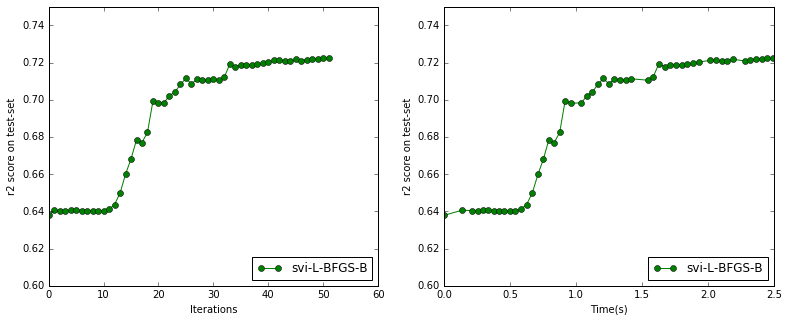

In [11]:
plot_results(lbfgs_svi_xi_lst, lbfgs_svi_xt_lst, lbfgs_svi_y_lst, '-go', 'svi-L-BFGS-B')

In [13]:
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_xi.npy', lbfgs_svi_xi_lst)
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_xt.npy', lbfgs_svi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_lbfgs_svi_y.npy', lbfgs_svi_y_lst)

## VI
L-BFGS-B optimization method applied to the vi objective (see the text).

In [14]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPR(model_covariance_obj, method='means', optimizer='L-BFGS-B')

In [15]:
opts = {'maxiter': 20, 'disp': True}
vi_res = vi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

In [16]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_xi_lst, vi_xt_lst, vi_y_lst = vi_res.plot_performance(metric, 'it', freq=1)

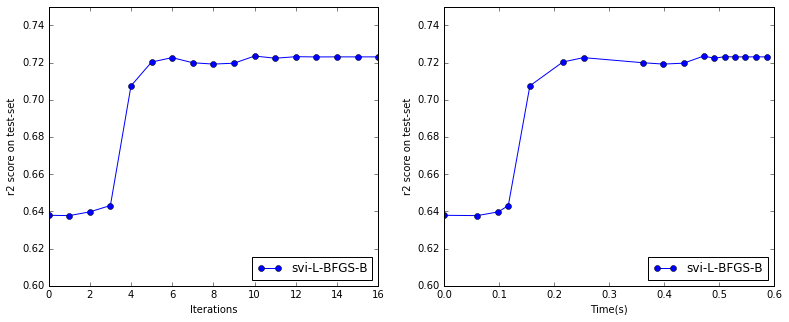

In [18]:
plot_results(vi_xi_lst, vi_xt_lst, vi_y_lst, '-bo', 'svi-L-BFGS-B')

In [19]:
vi_y_lst[-1]

0.72307314610437134

In [20]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_xi.npy', vi_xi_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_xt.npy', vi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_y.npy', vi_y_lst)

## Stochastic SVI
Stochastic (incremental) optimization methods applied to the svi objective (see the text).
### AdaDelta-Cholesky
Adadelta method from climin library.

In [15]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='AdaDelta')

In [16]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': 1.,
                'maxiter': 300, 'batch_size':200}
ad_svi_res = ad_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Using AdaDelta optimizer
Iteration  50 :
	Gradient norm 0.0430786213572
Iteration  100 :
	Gradient norm 0.402388655513
Iteration  150 :
	Gradient norm 0.16742416602
Iteration  200 :
	Gradient norm 0.323006808902
Iteration  250 :
	Gradient norm 0.356369315403
Iteration  300 :
	Gradient norm 0.320912039306


In [17]:
metric = lambda w: ad_svi_gp.get_prediction_quality(w, x_test, y_test)
ad_svi_xi_lst, ad_svi_xt_lst, ad_svi_y_lst = ad_svi_res.plot_performance(metric, 'it', freq=5)

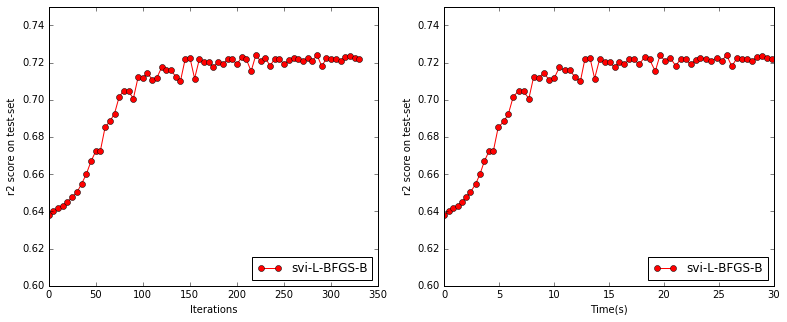

In [18]:
plot_results(ad_svi_xi_lst, ad_svi_xt_lst, ad_svi_y_lst, '-ro', 'svi-L-BFGS-B')

In [19]:
ad_svi_y_lst[-1]

0.72207172702619626

In [20]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_xi.npy', ad_svi_xi_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_xt.npy', ad_svi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_y.npy', ad_svi_y_lst)

###SG-cholesky
Stochastic gradient descent.

In [21]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sg_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='SG')

In [22]:
opts = {'maxiter':350, 'batch_size': 200 , 'print_freq': 50, 'step0': 9e-1, 'gamma': .2}
sg_svi_res = sg_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.9
	Parameters [ 1.00730956  4.98693837]
Epoch  50 :
	Step: 0.411574546735
	Parameters [ 0.81584872  4.46579491]
Epoch  100 :
	Step: 0.358296453498
	Parameters [ 0.77999302  3.6169645 ]
Epoch  150 :
	Step: 0.330387994426
	Parameters [ 0.57433436  2.6074532 ]
Epoch  200 :
	Step: 0.31191517942
	Parameters [ 0.47767637  2.17822606]
Epoch  250 :
	Step: 0.298300861561
	Parameters [ 0.47929032  2.07349437]
Epoch  300 :
	Step: 0.287619454654
	Parameters [ 0.48621872  2.01231396]


In [23]:
metric = lambda w: sg_svi_gp.get_prediction_quality(w, x_test, y_test)
sg_svi_x_lst, sg_svi_y_lst = sg_svi_res.plot_performance(metric, 'i', freq=5)

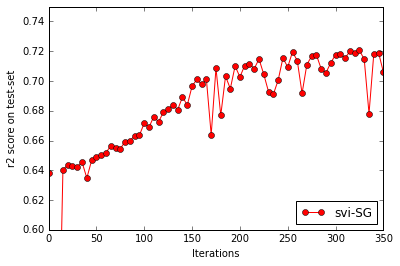

In [24]:
plt.plot(sg_svi_x_lst, sg_svi_y_lst, '-ro', label='svi-SG')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [25]:
sg_svi_y_lst[-1]

0.70593618171042904

In [26]:
np.save('../plots/regression_revision/mg/'+ data_name +'_sg_svi_x.npy', sg_svi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_sg_svi_y.npy', sg_svi_y_lst)

### SG-Natural
Stochastic gradient descent with natural gradients with respect to the variational parameters.

In [27]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural')

In [28]:
opts = {'maxiter':1000, 'batch_size': 300 , 'print_freq': 50, 'step0': 1., 'gamma': 0.2}
sng_svi_res = sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

1.0


ValueError: Unknown optimizer

In [ ]:
metric = lambda w: sng_svi_gp.get_prediction_quality(w, x_test, y_test)
sng_svi_x_lst, sng_svi_y_lst = sng_svi_res.plot_performance(metric, 'i', freq=10)

In [ ]:
plt.plot(sng_svi_x_lst, sng_svi_y_lst, '-yo', label='svi-natural')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [ ]:
sng_svi_y_lst[-1]

In [ ]:
np.max(sng_svi_y_lst)

In [ ]:
np.save('../plots/regression_revision/mg/'+ data_name +'_sng_svi_x.npy', sng_svi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_sng_svi_y.npy', sng_svi_y_lst)

### CliminSG-Natural

In [29]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural', optimizer='climinSG')

In [30]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': 3e-1,
                'maxiter': 1000, 'batch_size': 300 }
sng_svi_res = sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

1.0
Using SG optimizer
Iteration  49 :
	Gradient norm 0.337219841821
Iteration  99 :
	Gradient norm 0.373778422599
Iteration  149 :
	Gradient norm 0.185181192005
Iteration  199 :
	Gradient norm 0.120970110092
Iteration  249 :
	Gradient norm 0.155851965393
Iteration  298 :
	Gradient norm 0.167179405368
Iteration  348 :
	Gradient norm 0.364674252648
Iteration  398 :
	Gradient norm 0.541874116133
Iteration  448 :
	Gradient norm 0.263303113739
Iteration  498 :
	Gradient norm 0.0700403475937
Iteration  548 :
	Gradient norm 0.372993907606
Iteration  597 :
	Gradient norm 0.363817537105
Iteration  647 :
	Gradient norm 0.363628083934
Iteration  697 :
	Gradient norm 0.327930811192
Iteration  747 :
	Gradient norm 0.445122646128
Iteration  797 :
	Gradient norm 0.264177165523
Iteration  846 :
	Gradient norm 0.169768849942
Iteration  896 :
	Gradient norm 0.302938752337
Iteration  946 :
	Gradient norm 0.261652221522
Iteration  996 :
	Gradient norm 0.235673519643


In [31]:
metric = lambda w: sng_svi_gp.get_prediction_quality(w, x_test, y_test)
sng_svi_x_lst, sng_svi_y_lst = sng_svi_res.plot_performance(metric, 'i', freq=10)

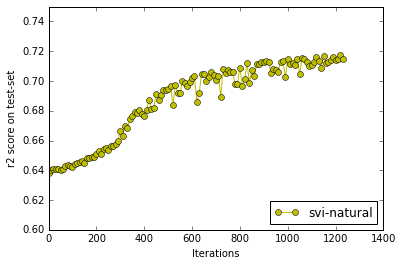

In [32]:
plt.plot(sng_svi_x_lst, sng_svi_y_lst, '-yo', label='svi-natural')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

as we can see the problem is not about my implementation of sgd.

### SG-Natural-ss
This method uses natural gradients for svi wrt variational parameters as svi-natural does. But this method chooses separate step-length for the to types of parameters it optimizes.

In [33]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ss_sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural', optimizer='climinSG')

In [34]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': .4,
                'maxiter': 500, 'batch_size': 300, 'nat_mult': 6.}
ss_sng_svi_res = ss_sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

6.0
Using SG optimizer
Iteration  49 :
	Gradient norm 0.881112526201
Iteration  99 :
	Gradient norm 0.186936571014
Iteration  149 :
	Gradient norm 0.183838303763
Iteration  199 :
	Gradient norm 0.704802965709
Iteration  249 :
	Gradient norm 0.989537893098
Iteration  298 :
	Gradient norm 0.657700072822
Iteration  348 :
	Gradient norm 1.39530388192
Iteration  398 :
	Gradient norm 0.708785501754
Iteration  448 :
	Gradient norm 0.959208638006
Iteration  498 :
	Gradient norm 0.860420770482


In [35]:
metric = lambda w: ss_sng_svi_gp.get_prediction_quality(w, x_test, y_test)
ss_sng_svi_x_lst, ss_sng_svi_y_lst = ss_sng_svi_res.plot_performance(metric, 'i', freq=10)

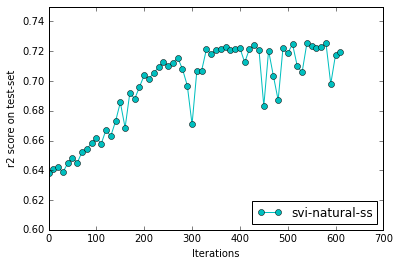

In [36]:
plt.plot(ss_sng_svi_x_lst, ss_sng_svi_y_lst, '-co', label='svi-natural-ss')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [37]:
np.save('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_x.npy', ss_sng_svi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_y.npy', ss_sng_svi_y_lst)

## SVI-SAG

In [8]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sag_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='SAG')

In [9]:
opts = {'maxiter':1000, 'batch_size': 300 , 'print_freq': 100}
sag_svi_res = sag_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Lipschitz constant estimate: 4.75682846001
	 [ 0.99354106  5.00004648]
Epoch  100 :
	Lipschitz constant estimate: 4.75682846001
	 [ 0.80656291  4.73697432]
Epoch  200 :
	Lipschitz constant estimate: 4.75682846001
	 [ 0.79777136  4.36884215]
Epoch  300 :
	Lipschitz constant estimate: 4.75682846001
	 [ 0.76771384  3.84097966]
Epoch  400 :
	Lipschitz constant estimate: 9.51365692002
	 [ 0.70374632  3.31197282]
Epoch  500 :
	Lipschitz constant estimate: 9.51365692002
	 [ 0.61662911  2.84126944]
Epoch  600 :
	Lipschitz constant estimate: 9.51365692002
	 [ 0.53495643  2.44622917]
Epoch  700 :
	Lipschitz constant estimate: 9.51365692002
	 [ 0.49075485  2.22266494]
Epoch  800 :
	Lipschitz constant estimate: 9.51365692002
	 [ 0.47203034  2.11861152]
Epoch  900 :
	Lipschitz constant estimate: 9.51365692002
	 [ 0.46294378  2.06029765]


In [10]:
metric = lambda w: sag_svi_gp.get_prediction_quality(w, x_test, y_test)
sag_svi_xi_lst, sag_svi_xt_lst, sag_svi_y_lst = sag_svi_res.plot_performance(metric, 'it', freq=10)

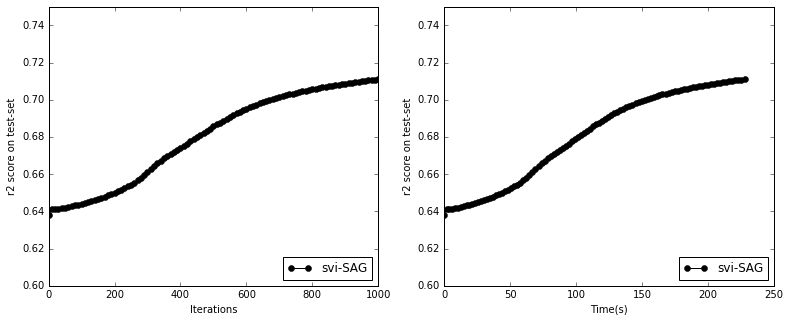

In [12]:
plot_results(sag_svi_xi_lst, sag_svi_xt_lst, sag_svi_y_lst, '-ko', 'svi-SAG')

# Stochastic methods

In [90]:
ad_svi_x_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_ad_svi_x.npy')
ad_svi_y_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_ad_svi_y.npy')
sng_svi_x_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_sng_svi_x.npy')
sng_svi_y_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_sng_svi_y.npy')
sg_svi_x_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_sg_svi_x.npy')
sg_svi_y_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_sg_svi_y.npy')
ss_sng_svi_x_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_x.npy')
ss_sng_svi_y_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_y.npy')

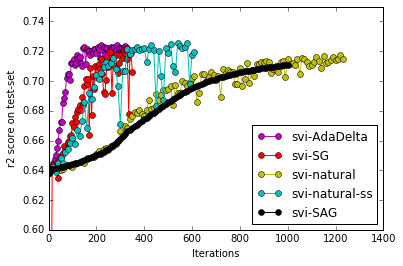

In [41]:
plt.plot(ad_svi_xi_lst, ad_svi_y_lst, '-mo', label='svi-AdaDelta')
plt.plot(sg_svi_x_lst, sg_svi_y_lst, '-ro', label='svi-SG')
plt.plot(sng_svi_x_lst, sng_svi_y_lst, '-yo', label='svi-natural')
plt.plot(ss_sng_svi_x_lst, ss_sng_svi_y_lst, '-co', label='svi-natural-ss')
plt.plot(sag_svi_xi_lst, sag_svi_y_lst, '-ko', label='svi-SAG')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')